#This is the colab demo for the S^3-TTA project, accepted and presented at ISBI 2024, Athen, Greece.

#This colab page is originally adopted and modified from the ZeroCostDL4Mic project from Henriques Laboratory (https://github.com/HenriquesLab/ZeroCostDL4Mic).

In [1]:
#@markdown ##Load the project repository from github
!git clone https://github.com/kangxian97/S3-TTA

Cloning into 'S3-TTA'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 318 (delta 16), reused 34 (delta 13), pack-reused 281
Receiving objects: 100% (318/318), 157.08 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (357/357), done.


In [2]:
#@markdown ##install packages & enter the repo directory
!pip uninstall -y -q yellowbrick
!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python-headless==4.1.2.30
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf
!pip install --upgrade fpdf2
!pip install fastremap

%cd /content/S3-TTA/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
geemap 0.32.1 requires folium>=0.13.0, but you have folium 0.2.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.7/562.7 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78

/content/S3-TTA


In [3]:
#@markdown ##Load key dependencies

Notebook_version = '1.15.3'
Network = 'Cellpose'

from builtins import any as b_any

%load_ext memory_profiler

def get_requirements_path():
    # Store requirements file in 'contents' directory
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]



# ------- Variable specific to Cellpose -------

from urllib.parse import urlparse
%matplotlib inline
from cellpose import models
#use_GPU = models.use_gpu()

#import mxnet as mx

from skimage.util import img_as_ubyte
import cv2
from cellpose import plot
from ipywidgets import interact, interact_manual
from zipfile import ZIP_DEFLATED


# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets


# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32
from skimage.util import img_as_ubyte
from tqdm import tqdm
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import subprocess
from pip._internal.operations.freeze import freeze

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print("Libraries installed")

# Check if this is the latest version of the notebook
All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


!pip freeze > requirements.txt

#Create a pdf document with training summary

def pdf_export(trained = False, augmentation = False, pretrained_model = False):
    # save FPDF() class into a
    # variable pdf
    #from datetime import datetime

    class MyFPDF(FPDF, HTMLMixin):
        pass

    pdf = MyFPDF()
    pdf.add_page()
    pdf.set_right_margin(-1)
    pdf.set_font("Arial", size = 11, style='B')


    day = datetime.now()
    datetime_str = str(day)[0:10]

    Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
    pdf.multi_cell(180, 5, txt = Header, align = 'L')

    # add another cell
    if trained:
      training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
      pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
    pdf.ln(1)

    Header_2 = 'Information for your materials and methods:'
    pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

    all_packages = ''
    for requirement in freeze(local_only=True):
      all_packages = all_packages+requirement+', '
    #print(all_packages)

    #Main Packages
    main_packages = ''
    version_numbers = []
    for name in ['tensorflow','numpy','Keras','csbdeep']:
      find_name=all_packages.find(name)
      main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
      #Version numbers only here:
      version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

    cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
    cuda_version = cuda_version.stdout.decode('utf-8')
    cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
    gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
    gpu_name = gpu_name.stdout.decode('utf-8')
    gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
    #print(cuda_version[cuda_version.find(', V')+3:-1])
    #print(gpu_name)

    shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
    dataset_size = len(os.listdir(Training_source))

    text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'


    if pretrained_model:
      text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

    # print(text)

    pdf.set_font('')
    pdf.set_font_size(10.)
    pdf.multi_cell(190, 5, txt = text, align='L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.ln(1)
    pdf.cell(28, 5, txt='Augmentation: ', ln=0)
    pdf.set_font('')
    if augmentation:
      aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)

    else:
      aug_text = 'No augmentation was used for training.'
    pdf.multi_cell(190, 5, txt=aug_text, align='L')
    pdf.set_font('Arial', size = 11, style = 'B')
    pdf.ln(1)
    pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font_size(10.)
    if Use_Default_Advanced_Parameters:
      pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
    pdf.cell(200, 5, txt='The following parameters were used for training:')
    pdf.ln(1)
    html = """
    <table width=40% style="margin-left:0px;">
      <tr>
        <th width = 50% align="left">Parameter</th>
        <th width = 50% align="left">Value</th>
      </tr>
      <tr>
        <td width = 50%>number_of_epochs</td>
        <td width = 50%>{0}</td>
      </tr>
      <tr>
        <td width = 50%>batch_size</td>
        <td width = 50%>{1}</td>
      </tr>
      <tr>
        <td width = 50%>percentage_validation</td>
        <td width = 50%>{2}</td>
      </tr>
      <tr>
        <td width = 50%>initial_learning_rate</td>
        <td width = 50%>{3}</td>
      </tr>
    </table>
    """.format(number_of_epochs,batch_size,percentage_validation,initial_learning_rate)
    pdf.write_html(html)

    #pdf.multi_cell(190, 5, txt = text_2, align='L')
    pdf.set_font("Arial", size = 11, style='B')
    pdf.ln(1)
    pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(27, 5, txt= 'Training_target:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
    #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
    pdf.ln(1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(22, 5, txt= 'Model Path:', align = 'L', ln=0)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
    pdf.ln(1)
    pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
    pdf.ln(1)
    exp_size = io.imread('/content/TrainingDataExample_Cellpose2D.png').shape
    pdf.image('/content/TrainingDataExample_Cellpose2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
    pdf.ln(1)
    ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
    pdf.multi_cell(190, 5, txt = ref_1, align='L')
    ref_2 = '- Cellpose: Stringer, Carsen, et al. "Cellpose: a generalist algorithm for cellular segmentation." Nature Methods 18, pages100-106(2021).'
    pdf.multi_cell(190, 5, txt = ref_2, align='L')
    pdf.ln(3)
    reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
    pdf.set_font('Arial', size = 11, style='B')
    pdf.multi_cell(190, 5, txt=reminder, align='C')

    pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")
    # pdf.output(Saving_path+'/train_folder/models/'+model_name+"_training_report.pdf")



#Make a pdf summary of the QC results

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B')

  Network = 'Cellpose 2D'
  #model_name = os.path.basename(full_QC_model_path)
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/13))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.', align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=94% style="margin-left:0px;">"""
  with open(full_QC_model_path+'Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    mSSIM_PvsGT = header[1]
    mSSIM_SvsGT = header[2]
    NRMSE_PvsGT = header[3]
    NRMSE_SvsGT = header[4]
    PSNR_PvsGT = header[5]
    PSNR_SvsGT = header[6]
    header = """
    <tr>
      <th width = 10% align="left">{0}</th>
      <th width = 15% align="left">{1}</th>
      <th width = 15% align="center">{2}</th>
      <th width = 15% align="left">{3}</th>
      <th width = 15% align="center">{4}</th>
      <th width = 15% align="left">{5}</th>
      <th width = 15% align="center">{6}</th>
    </tr>""".format(image,mSSIM_PvsGT,mSSIM_SvsGT,NRMSE_PvsGT,NRMSE_SvsGT,PSNR_PvsGT,PSNR_SvsGT)
    html = html+header
    for row in metrics:
      image = row[0]
      mSSIM_PvsGT = row[1]
      mSSIM_SvsGT = row[2]
      NRMSE_PvsGT = row[3]
      NRMSE_SvsGT = row[4]
      PSNR_PvsGT = row[5]
      PSNR_SvsGT = row[6]
      cells = """
        <tr>
          <td width = 10% align="left">{0}</td>
          <td width = 15% align="center">{1}</td>
          <td width = 15% align="center">{2}</td>
          <td width = 15% align="center">{3}</td>
          <td width = 15% align="center">{4}</td>
          <td width = 15% align="center">{5}</td>
          <td width = 15% align="center">{6}</td>
        </tr>""".format(image,str(round(float(mSSIM_PvsGT),3)),str(round(float(mSSIM_SvsGT),3)),str(round(float(NRMSE_PvsGT),3)),str(round(float(NRMSE_SvsGT),3)),str(round(float(PSNR_PvsGT),3)),str(round(float(PSNR_SvsGT),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "ZeroCostDL4Mic: an open platform to simplify access and use of Deep-Learning in Microscopy." BioRxiv (2020).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- CARE: Weigert, Martin, et al. "Content-aware image restoration: pushing the limits of fluorescence microscopy." Nature methods 15.12 (2018): 1090-1097.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'Quality Control/'+QC_model_name+'_QC_report.pdf')


# Build requirements file for local run
after = [str(m) for m in sys.modules]
#build_requirements_file(before, after)


/usr/local/lib/python3.10/dist-packages/fpdf/__init__.py:39: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Libraries installed
Notebook version: 1.15.3
Latest notebook version: 1.16.3
A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki


In [4]:
import os
import cellpose
from cellpose import utils, models, io, core
#@markdown ###load the style transfer(Adain decoder) and the cellpose segmentation model (please use the default checkpoints for now):
QC_model_path = "/content/S3-TTA/1style_3scale_ckps/cellpose_3Scale_1Style_2023_02_25_17_32_31.738253" #@param {type:"string"}
QC_adain_path = "/content/S3-TTA/1style_3scale_ckps/adain_decoder_3Scale_1Style_2023_02_25_17_32_31.738253" #@param {type:"string"}
#@markdown ###directory containing the style images
styles_dir = '/content/S3-TTA/style_anchors_1'#@param {type:"string"}
#@markdown ###Select the scaling options
scale1 = 0.8 #@param {type:"slider", min:0.7, max:3.5, step:0.1}
scale2 = 1.5 #@param {type:"slider", min:0.7, max:3.5, step:0.1}
scale3 = 2 #@param {type:"slider", min:0.7, max:3.5, step:0.1}
image_scales = [scale1,scale2,scale3]
if os.path.exists(QC_model_path) and os.path.exists(QC_adain_path):
  model = models.CellposeModel(gpu=True,  pretrained_model=QC_model_path, pretrained_model_adain = QC_adain_path, diam_mean=30.0, net_avg=True, style_anchor_dir = styles_dir)
  QC_model_folder = os.path.dirname(QC_model_path)
  Saving_path = QC_model_folder
  QC_model_name = os.path.basename(QC_model_folder)
  print("The "+str(QC_model_name)+" model will be evaluated")

else:
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!')
  print('Please make sure you provide a valid model path and model name before proceeding further.')

#Here we make the folder to save the resuslts if it does not exists

if not Saving_path == "":
  if os.path.exists(QC_model_folder) == False:
    os.makedirs(QC_model_folder)
else:
  print(bcolors.WARNING+'!! WARNING: Indicate where you want to save the results')


# Here we load the def that perform the QC, code taken from StarDist  https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py

import numpy as np
from numba import jit
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import namedtuple


matching_criteria = dict()

def label_are_sequential(y):
    """ returns true if y has only sequential labels from 1... """
    labels = np.unique(y)
    return (set(labels)-{0}) == set(range(1,1+labels.max()))


def is_array_of_integers(y):
    return isinstance(y,np.ndarray) and np.issubdtype(y.dtype, np.integer)


def _check_label_array(y, name=None, check_sequential=False):
    err = ValueError("{label} must be an array of {integers}.".format(
        label = 'labels' if name is None else name,
        integers = ('sequential ' if check_sequential else '') + 'non-negative integers',
    ))
    is_array_of_integers(y) or print("An error occured")
    if check_sequential:
        label_are_sequential(y) or print("An error occured")
    else:
        y.min() >= 0 or print("An error occured")
    return True


def label_overlap(x, y, check=True):
    if check:
        _check_label_array(x,'x',True)
        _check_label_array(y,'y',True)
        x.shape == y.shape or _raise(ValueError("x and y must have the same shape"))
    return _label_overlap(x, y)

@jit(nopython=True)
def _label_overlap(x, y):
    x = x.ravel()
    y = y.ravel()
    overlap = np.zeros((1+x.max(),1+y.max()), dtype=np.uint)
    for i in range(len(x)):
        overlap[x[i],y[i]] += 1
    return overlap


def intersection_over_union(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / (n_pixels_pred + n_pixels_true - overlap)

matching_criteria['iou'] = intersection_over_union


def intersection_over_true(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    return overlap / n_pixels_true

matching_criteria['iot'] = intersection_over_true


def intersection_over_pred(overlap):
    _check_label_array(overlap,'overlap')
    if np.sum(overlap) == 0:
        return overlap
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    return overlap / n_pixels_pred

matching_criteria['iop'] = intersection_over_pred


def precision(tp,fp,fn):
    return tp/(tp+fp) if tp > 0 else 0
def recall(tp,fp,fn):
    return tp/(tp+fn) if tp > 0 else 0
def accuracy(tp,fp,fn):
    # also known as "average precision" (?)
    # -> https://www.kaggle.com/c/data-science-bowl-2018#evaluation
    return tp/(tp+fp+fn) if tp > 0 else 0
def f1(tp,fp,fn):
    # also known as "dice coefficient"
    return (2*tp)/(2*tp+fp+fn) if tp > 0 else 0


def _safe_divide(x,y):
    return x/y if y>0 else 0.0

def matching(y_true, y_pred, thresh=0.5, criterion='iou', report_matches=False):
    """Calculate detection/instance segmentation metrics between ground truth and predicted label images.
    Currently, the following metrics are implemented:
    'fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'
    Corresponding objects of y_true and y_pred are counted as true positives (tp), false positives (fp), and false negatives (fn)
    whether their intersection over union (IoU) >= thresh (for criterion='iou', which can be changed)
    * mean_matched_score is the mean IoUs of matched true positives
    * mean_true_score is the mean IoUs of matched true positives but normalized by the total number of GT objects
    * panoptic_quality defined as in Eq. 1 of Kirillov et al. "Panoptic Segmentation", CVPR 2019
    Parameters
    ----------
    y_true: ndarray
        ground truth label image (integer valued)
        predicted label image (integer valued)
    thresh: float
        threshold for matching criterion (default 0.5)
    criterion: string
        matching criterion (default IoU)
    report_matches: bool
        if True, additionally calculate matched_pairs and matched_scores (note, that this returns even gt-pred pairs whose scores are below  'thresh')
    Returns
    -------
    Matching object with different metrics as attributes
    Examples
    --------
    >>> y_true = np.zeros((100,100), np.uint16)
    >>> y_true[10:20,10:20] = 1
    >>> y_pred = np.roll(y_true,5,axis = 0)
    >>> stats = matching(y_true, y_pred)
    >>> print(stats)
    Matching(criterion='iou', thresh=0.5, fp=1, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=1, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0)
    """
    _check_label_array(y_true,'y_true')
    _check_label_array(y_pred,'y_pred')
    y_true.shape == y_pred.shape or _raise(ValueError("y_true ({y_true.shape}) and y_pred ({y_pred.shape}) have different shapes".format(y_true=y_true, y_pred=y_pred)))
    criterion in matching_criteria or _raise(ValueError("Matching criterion '%s' not supported." % criterion))
    if thresh is None: thresh = 0
    thresh = float(thresh) if np.isscalar(thresh) else map(float,thresh)

    y_true, _, map_rev_true = relabel_sequential(y_true)
    y_pred, _, map_rev_pred = relabel_sequential(y_pred)

    overlap = label_overlap(y_true, y_pred, check=False)
    scores = matching_criteria[criterion](overlap)
    assert 0 <= np.min(scores) <= np.max(scores) <= 1

    # ignoring background
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    def _single(thr):
        not_trivial = n_matched > 0 and np.any(scores >= thr)
        if not_trivial:
            # compute optimal matching with scores as tie-breaker
            costs = -(scores >= thr).astype(float) - scores / (2*n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            assert n_matched == len(true_ind) == len(pred_ind)
            match_ok = scores[true_ind,pred_ind] >= thr
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        fp = n_pred - tp
        fn = n_true - tp
        # assert tp+fp == n_pred
        # assert tp+fn == n_true

        # the score sum over all matched objects (tp)
        sum_matched_score = np.sum(scores[true_ind,pred_ind][match_ok]) if not_trivial else 0.0

        # the score average over all matched objects (tp)
        mean_matched_score = _safe_divide(sum_matched_score, tp)
        # the score average over all gt/true objects
        mean_true_score    = _safe_divide(sum_matched_score, n_true)
        panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

        stats_dict = dict (
            criterion          = criterion,
            thresh             = thr,
            fp                 = fp,
            tp                 = tp,
            fn                 = fn,
            precision          = precision(tp,fp,fn),
            recall             = recall(tp,fp,fn),
            accuracy           = accuracy(tp,fp,fn),
            f1                 = f1(tp,fp,fn),
            n_true             = n_true,
            n_pred             = n_pred,
            mean_true_score    = mean_true_score,
            mean_matched_score = mean_matched_score,
            panoptic_quality   = panoptic_quality,
        )
        if bool(report_matches):
            if not_trivial:
                stats_dict.update (
                    # int() to be json serializable
                    matched_pairs  = tuple((int(map_rev_true[i]),int(map_rev_pred[j])) for i,j in zip(1+true_ind,1+pred_ind)),
                    matched_scores = tuple(scores[true_ind,pred_ind]),
                    matched_tps    = tuple(map(int,np.flatnonzero(match_ok))),
                )
            else:
                stats_dict.update (
                    matched_pairs  = (),
                    matched_scores = (),
                    matched_tps    = (),
                )
        return namedtuple('Matching',stats_dict.keys())(*stats_dict.values())

    return _single(thresh) if np.isscalar(thresh) else tuple(map(_single,thresh))



def matching_dataset(y_true, y_pred, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):
    """matching metrics for list of images, see `stardist.matching.matching`
    """
    len(y_true) == len(y_pred) or _raise(ValueError("y_true and y_pred must have the same length."))
    return matching_dataset_lazy (
        tuple(zip(y_true,y_pred)), thresh=thresh, criterion=criterion, by_image=by_image, show_progress=show_progress, parallel=parallel,
    )



def matching_dataset_lazy(y_gen, thresh=0.5, criterion='iou', by_image=False, show_progress=True, parallel=False):

    expected_keys = set(('fp', 'tp', 'fn', 'precision', 'recall', 'accuracy', 'f1', 'criterion', 'thresh', 'n_true', 'n_pred', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'))

    single_thresh = False
    if np.isscalar(thresh):
        single_thresh = True
        thresh = (thresh,)

    tqdm_kwargs = {}
    tqdm_kwargs['disable'] = not bool(show_progress)
    if int(show_progress) > 1:
        tqdm_kwargs['total'] = int(show_progress)

    # compute matching stats for every pair of label images
    if parallel:
        from concurrent.futures import ThreadPoolExecutor
        fn = lambda pair: matching(*pair, thresh=thresh, criterion=criterion, report_matches=False)
        with ThreadPoolExecutor() as pool:
            stats_all = tuple(pool.map(fn, tqdm(y_gen,**tqdm_kwargs)))
    else:
        stats_all = tuple (
            matching(y_t, y_p, thresh=thresh, criterion=criterion, report_matches=False)
            for y_t,y_p in tqdm(y_gen,**tqdm_kwargs)
        )

    # accumulate results over all images for each threshold separately
    n_images, n_threshs = len(stats_all), len(thresh)
    accumulate = [{} for _ in range(n_threshs)]
    for stats in stats_all:
        for i,s in enumerate(stats):
            acc = accumulate[i]
            for k,v in s._asdict().items():
                if k == 'mean_true_score' and not bool(by_image):
                    # convert mean_true_score to "sum_matched_score"
                    acc[k] = acc.setdefault(k,0) + v * s.n_true
                else:
                    try:
                        acc[k] = acc.setdefault(k,0) + v
                    except TypeError:
                        pass

    # normalize/compute 'precision', 'recall', 'accuracy', 'f1'
    for thr,acc in zip(thresh,accumulate):
        set(acc.keys()) == expected_keys or _raise(ValueError("unexpected keys"))
        acc['criterion'] = criterion
        acc['thresh'] = thr
        acc['by_image'] = bool(by_image)
        if bool(by_image):
            for k in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
                acc[k] /= n_images
        else:
            tp, fp, fn, n_true = acc['tp'], acc['fp'], acc['fn'], acc['n_true']
            sum_matched_score = acc['mean_true_score']

            mean_matched_score = _safe_divide(sum_matched_score, tp)
            mean_true_score    = _safe_divide(sum_matched_score, n_true)
            panoptic_quality   = _safe_divide(sum_matched_score, tp+fp/2+fn/2)

            acc.update(
                precision          = precision(tp,fp,fn),
                recall             = recall(tp,fp,fn),
                accuracy           = accuracy(tp,fp,fn),
                f1                 = f1(tp,fp,fn),
                mean_true_score    = mean_true_score,
                mean_matched_score = mean_matched_score,
                panoptic_quality   = panoptic_quality,
            )

    accumulate = tuple(namedtuple('DatasetMatching',acc.keys())(*acc.values()) for acc in accumulate)
    return accumulate[0] if single_thresh else accumulate



# copied from scikit-image master for now (remove when part of a release)
def relabel_sequential(label_field, offset=1):
    """Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.
    This function also returns the forward map (mapping the original labels to
    the reduced labels) and the inverse map (mapping the reduced labels back
    to the original ones).
    Parameters
    ----------
    label_field : numpy array of int, arbitrary shape
        An array of labels, which must be non-negative integers.
    offset : int, optional
        The return labels will start at `offset`, which should be
        strictly positive.
    Returns
    -------
    relabeled : numpy array of int, same shape as `label_field`
        The input label field with labels mapped to
        {offset, ..., number_of_labels + offset - 1}.
        The data type will be the same as `label_field`, except when
        offset + number_of_labels causes overflow of the current data type.
    forward_map : numpy array of int, shape ``(label_field.max() + 1,)``
        The map from the original label space to the returned label
        space. Can be used to re-apply the same mapping. See examples
        for usage. The data type will be the same as `relabeled`.
    inverse_map : 1D numpy array of int, of length offset + number of labels
        The map from the new label space to the original space. This
        can be used to reconstruct the original label field from the
        relabeled one. The data type will be the same as `relabeled`.
    Notes
    -----
    The label 0 is assumed to denote the background and is never remapped.
    The forward map can be extremely big for some inputs, since its
    length is given by the maximum of the label field. However, in most
    situations, ``label_field.max()`` is much smaller than
    ``label_field.size``, and in these cases the forward map is
    guaranteed to be smaller than either the input or output images.
    Examples
    --------
    >>> from skimage.segmentation import relabel_sequential
    >>> label_field = np.array([1, 1, 5, 5, 8, 99, 42])
    >>> relab, fw, inv = relabel_sequential(label_field)
    >>> relab
    array([1, 1, 2, 2, 3, 5, 4])
    >>> fw
    array([0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])
    >>> inv
    array([ 0,  1,  5,  8, 42, 99])
    >>> (fw[label_field] == relab).all()
    True
    >>> (inv[relab] == label_field).all()
    True
    >>> relab, fw, inv = relabel_sequential(label_field, offset=5)
    >>> relab
    array([5, 5, 6, 6, 7, 9, 8])
    """
    offset = int(offset)
    if offset <= 0:
        raise ValueError("Offset must be strictly positive.")
    if np.min(label_field) < 0:
        raise ValueError("Cannot relabel array that contains negative values.")
    max_label = int(label_field.max()) # Ensure max_label is an integer
    if not np.issubdtype(label_field.dtype, np.integer):
        new_type = np.min_scalar_type(max_label)
        label_field = label_field.astype(new_type)
    labels = np.unique(label_field)
    labels0 = labels[labels != 0]
    new_max_label = offset - 1 + len(labels0)
    new_labels0 = np.arange(offset, new_max_label + 1)
    output_type = label_field.dtype
    required_type = np.min_scalar_type(new_max_label)
    if np.dtype(required_type).itemsize > np.dtype(label_field.dtype).itemsize:
        output_type = required_type
    forward_map = np.zeros(max_label + 1, dtype=output_type)
    forward_map[labels0] = new_labels0
    inverse_map = np.zeros(new_max_label + 1, dtype=output_type)
    inverse_map[offset:] = labels0
    relabeled = forward_map[label_field]
    return relabeled, forward_map, inverse_map





created Unet Model
1 10
in if /content/S3-TTA/1style_3scale_ckps/cellpose_3Scale_1Style_2023_02_25_17_32_31.738253
The 1style_3scale_ckps model will be evaluated


/content/S3-TTA/1style_3scale_ckps/Quality Control/Prediction
Performing prediction on: img_000.tif
scale 0.8  style 0 rot_consis: 0.9146988812873286
scale 1.5  style 0 rot_consis: 0.9665423691381246
scale 2  style 0 rot_consis: 0.9748043511037837
scale 1.0  style 0 rot_consis: 0.93947975736367
Scale selection:  2 Style selction (index): 0
Performing prediction on: img_001.tif
scale 0.8  style 0 rot_consis: 0.9341415616631954
scale 1.5  style 0 rot_consis: 0.9691716491360549
scale 2  style 0 rot_consis: 0.9754403180114765
scale 1.0  style 0 rot_consis: 0.9489585493583074
Scale selection:  2 Style selction (index): 0
Performing prediction on: img_002.tif
scale 0.8  style 0 rot_consis: 0.935434098337212
scale 1.5  style 0 rot_consis: 0.9711453816287438
scale 2  style 0 rot_consis: 0.9790308423982513
scale 1.0  style 0 rot_consis: 0.950830150840911
Scale selection:  2 Style selction (index): 0
Performing prediction on: img_003.tif
scale 0.8  style 0 rot_consis: 0.9404516418345529
scale 1.

interactive(children=(Dropdown(description='file', options=('img_060.tif', 'img_014.tif', 'img_020.tif', 'img_…

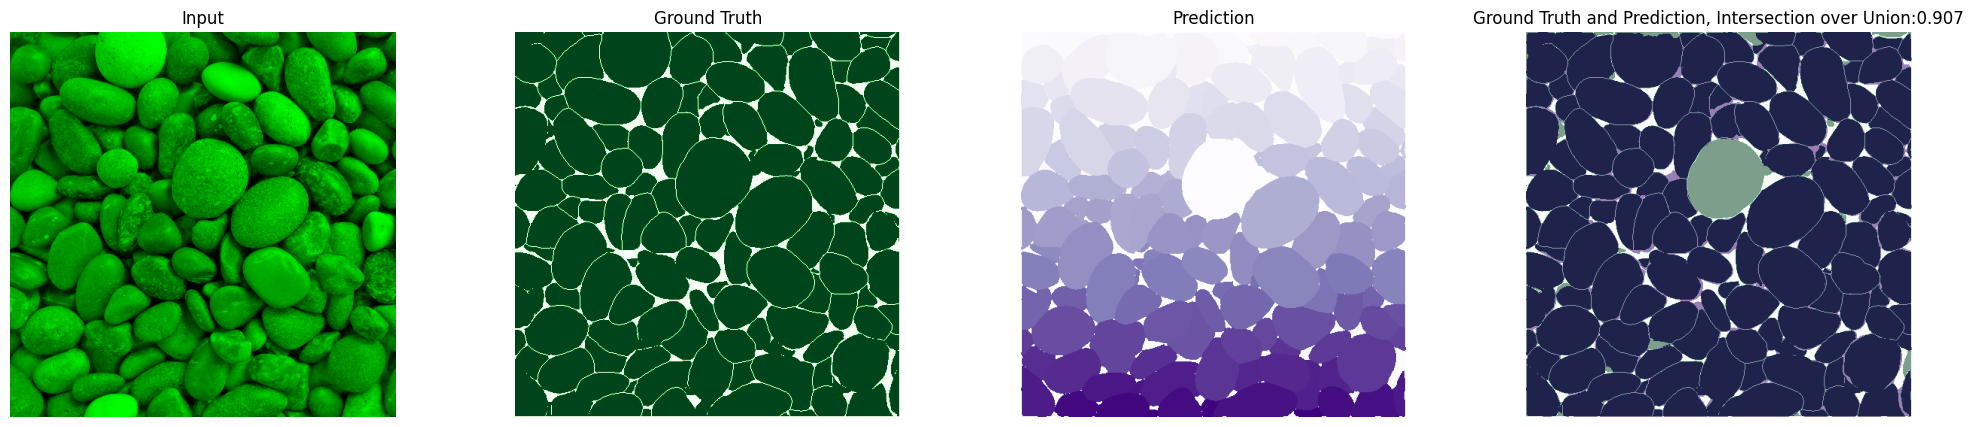

In [5]:
#@markdown ##Choose the folders that contain your Quality Control dataset

Source_QC_folder = "/content/S3-TTA/cellpose_testset/test_img_tif" #@param{type:"string"}
Target_QC_folder = "/content/S3-TTA/cellpose_testset/test_mask_tif" #@param{type:"string"}

#@markdown ##Choose the channel that contains the grayscale cell image
Channel_to_segment= 1 #@param ["0", "1", "2"] #

random_choice = random.choice(os.listdir(Source_QC_folder))
x = io.imread(Source_QC_folder+"/"+random_choice)
n_channel = 1 if x.ndim == 2 else x.shape[-1]

#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_folder+"/Quality Control") == False:
  os.makedirs(QC_model_folder+"/Quality Control")

if os.path.exists(QC_model_folder+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_folder+"/Quality Control/Prediction")
os.makedirs(QC_model_folder+"/Quality Control/Prediction")
print(QC_model_folder+"/Quality Control/Prediction")

# Here we need to make predictions
for ind, name in enumerate(sorted(os.listdir(Source_QC_folder))):
  print("Performing prediction on: "+name)
  image = io.imread(Source_QC_folder+"/"+name)
  short_name = os.path.splitext(name)
  masks, flows = model.eval(image, image_scales, channel=Channel_to_segment)

  os.chdir(QC_model_folder+"/Quality Control/Prediction")
  imsave(str(short_name[0])+".tif", masks)#, compress=ZIP_DEFLATED)

# Here we start testing the differences between GT and predicted masks

#iou thresholds for F1 score caluclation
threshold = 0.5

with open(QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])

    for ind,n in enumerate(os.listdir(Source_QC_folder)):
        #if ind==2:break
        if not os.path.isdir(os.path.join(Source_QC_folder,n)):
            print('Running QC on: '+n)
            test_input = io.imread(os.path.join(Source_QC_folder,n))
            test_prediction = io.imread(os.path.join(QC_model_folder+"/Quality Control/Prediction",n))
            test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, n))

            # Calculate the matching (with IoU threshold `thresh`) and all metrics
            print(test_input.shape,test_prediction.shape, test_ground_truth_image.shape)
            stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)


            #Convert pixel values to 0 or 255
            test_prediction_0_to_255 = test_prediction
            test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

            #Convert pixel values to 0 or 255
            test_ground_truth_0_to_255 = test_ground_truth_image
            test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


            # Intersection over Union metric

            intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
            union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
            iou_score =  np.sum(intersection) / np.sum(union)
            writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])

from tabulate import tabulate

df = pd.read_csv (QC_model_folder+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


from astropy.visualization import simple_norm

# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):


  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = io.imread(os.path.join(Source_QC_folder, file))#, as_gray = True)

  target_image = io.imread(os.path.join(Target_QC_folder, file))#, as_gray = True)
  prediction = io.imread(QC_model_folder+"/Quality Control/Prediction/"+file)#, as_gray = True)
  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0

  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  #plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.imshow(prediction, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(QC_model_folder+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)


full_QC_model_path = QC_model_folder+'/'
#qc_pdf_export()



The instance-segmentation results are recorded at:
 checkpoint's folder/Quality_Control

 e.g. if the checkpoint is: /content/S3-TTA/1style_3scale_ckps/cellpose_3Scale_1Style_2023_02_25_17_32_31.738253

 the results will be in: /content/S3-TTA/1style_3scale_ckps/Quality_Control